<font color='blue'> **<font color='red'> **11_** </font> 12 13 14 15 51  SFR, SFR2, LAK, MRV** </font> 

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True)  ; plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
import os;import flopy;import matplotlib.pyplot as plt;import numpy as np;import pickle        ; from pathlib import Path;from flopy.plot.styles import styles;import pandas as pd ; import csv
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/11_ex-gwf-sfr-p01')                               ; ID= "e11"   ; import shutil    ; import modflowapi 
_R=Path("./_R");_R.mkdir(exist_ok=True)  ;T11=Path("./_R/T11");T11.mkdir(exist_ok=True)        ; T11b=Path("./_R/T11/b");T11b.mkdir(exist_ok=True)        

with open(REF1/ "c_sfr_div    " ,'rb') as handle: SFR_D  = pickle.load(handle)                 # (https://modflow6-examples.readthedocs.io/en/develop/_examples/ex-gwf-sfr-p01.html ) 
with open(REF1/ "e_ghb_spd    " ,'rb') as handle: GHB_S  = pickle.load(handle)                 # (https://modflow6-examples.readthedocs.io/en/develop/_notebooks/ex-gwf-sfr-p01.html)              
with open(REF1/ "f_wel_spd    " ,'rb') as handle: WEL_S  = pickle.load(handle)                 #  with open(REF1/ "obs_list    " ,'rb')  as handle: OBS_L  = pickle.load(handle)   
IDO  = np.loadtxt(REF1/"idomain.txt" , dtype = int)      ; TOP = np.loadtxt(REF1/"top.txt"  ,dtype = float)  ; BOTM  = np.loadtxt(REF1/"bottom.txt", dtype = float) 
RCH  = np.loadtxt(REF1/"recharge.txt", dtype = float)    ; SURF = np.loadtxt(REF1/"surf.txt",dtype = float)   

nrow=15;ncol=10 ; delr=5000   ;delc=5000  ;IC=1050  ;SS=0.000001 ;EVPT=0.000000095 ;D_EVPT=15 ;K11_S=0.002        ; SY_S=0.2 ;K11_B=0.0004 ;SY_B=0.1
nouter = 100    ; ninner = 50 ; hclose = 0.000001   ; rclose = 0.000001                                           ; NPER=3   ;TDIS=((0.0 ,1 ,1.0),(1.577880e9 ,50 ,1.1),(1.577880e9 ,50 ,1.1))
S2D=(nrow,ncol) ; K11 = np.zeros(S2D, dtype=float)  ; K11[IDO==1]=K11_S ;K11[IDO==2]=K11_B                        ; SY = np.zeros(S2D, dtype=float) ; SY[IDO==1]=SY_S ;SY[IDO==2]=SY_B   
OBS_F = f"{ID}.sfr.obs"  ; csv_file = OBS_F + ".csv"                                                              ; print('TDIS (50+50y pump/recovery)=', TDIS,'.. 100 years')
OBS_D = {csv_file: [("H4", "stage", (3,))            ,("H15", "stage", (14,))           ,("H27", "stage", (26,))           ,("H35", "stage"          , (35,)),
                    ("Q4", "downstream-flow", (3,))  ,("Q15", "downstream-flow", (14,)) ,("Q27", "downstream-flow" ,(26,)) ,("Q35", "downstream-flow", (35,))]}
print('RCH:',round(np.mean(RCH)*60*60*24*365,4),'m3/m2 | m/year')       ; EVPT=0.00000000095

TDIS (50+50y pump/recovery)= ((0.0, 1, 1.0), (1577880000.0, 50, 1.1), (1577880000.0, 50, 1.1)) .. 100 years
RCH: 0.0151 m3/m2 | m/year


In [2]:
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')       ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()         #; SFR_C
SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).dropna(how='all').values.tolist()                                                         
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).dropna(how='all')       ; SFR_P = df.to_records(index=False)    ; print('GHB | Z_row(y)_col(x) |Q|C',GHB_S)  

GHB | Z_row(y)_col(x) |Q|C [[0, 12, 0, 988.0, 0.038], [0, 13, 8, 1045.0, 0.038]]


In [3]:
def build_models():
    sim = flopy.mf6.MFSimulation  (sim_name=ID   ,sim_ws=T11b)                     ; flopy.mf6.ModflowTdis(sim , nper=NPER ,perioddata=TDIS ,time_units="seconds") ;aa="summary";bb="bicgstab"
    flopy.mf6.ModflowIms     (sim, print_option=aa,linear_acceleration=bb, outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=ID, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf, length_units="feet",nlay=1,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=IDO,top=TOP,botm=BOTM)    ; flopy.mf6.ModflowGwfrcha (gwf, recharge=RCH)
    flopy.mf6.ModflowGwfnpf  (gwf, icelltype=1,k=K11,save_specific_discharge=True)     ; flopy.mf6.ModflowGwfsto  (gwf, iconvert=1,sy=SY,ss=SS,steady_state={0: True},transient={1: True})
    flopy.mf6.ModflowGwfic   (gwf, strt=IC)                                            ; flopy.mf6.ModflowGwfghb  (gwf, stress_period_data=GHB_S)
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data=WEL_S)                           ; flopy.mf6.ModflowGwfevta (gwf, surface=SURF, rate=EVPT, depth=D_EVPT)

    sfr = flopy.mf6.ModflowGwfsfr (gwf,length_conversion=3.28081,nreaches=len(SFR_P),packagedata=SFR_P,connectiondata=SFR_C,  diversions=SFR_D,perioddata=SFR_S)        # _P_C_D_S
    sfr.obs.initialize            (filename=OBS_F, digits=10, print_input=True, continuous=OBS_D)                                  

    HF=f"{ID}.hds";BF=f"{ID}.cbc"   ; flopy.mf6.ModflowGwfoc(gwf,head_filerecord=HF,budget_filerecord=BF,saverecord=[("HEAD","LAST"),("BUDGET","LAST")]) ;return sim

def write_models(sim, silent=True):   sim.write_simulation(silent=silent)
def run_models  (sim, silent=True):   success, buff = sim.run_simulation(silent=silent) ; assert success, buff
def scenario(): 
    sim = build_models()
    if write:    write_models(sim, silent=True) ; 
    if run:      run_models  (sim, silent=True)
scenario()

<font color='blue'> **RES** </font> 

In [4]:
sim = flopy.mf6.MFSimulation.load (sim_ws = T11b , verbosity_level=0)  ;GWF=sim.get_model("e11");HOBJ=GWF.output.head();COBJ=GWF.output.budget();kstpkper=HOBJ.get_kstpkper() ; print('NPER:',kstpkper)
SA =np.max(TOP)-np.min(TOP)     ;LT=np.arange(np.min(TOP[0]),np.max(TOP[0]), SA/60)  ;SB=np.max(BOTM)-np.min(BOTM)              ; LEV=np.arange(np.min(BOTM[0]), np.max(BOTM[0]), SB/10)    

Y0=0; head0 = HOBJ.get_data(kstpkper=kstpkper[Y0])    ;QX0,QY0,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y0])[0], GWF)
Y1=1; head1 = HOBJ.get_data(kstpkper=kstpkper[Y1])    ;QX1,QY1,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y1])[0], GWF)

NPER: [(0, 0), (49, 1), (49, 2)]


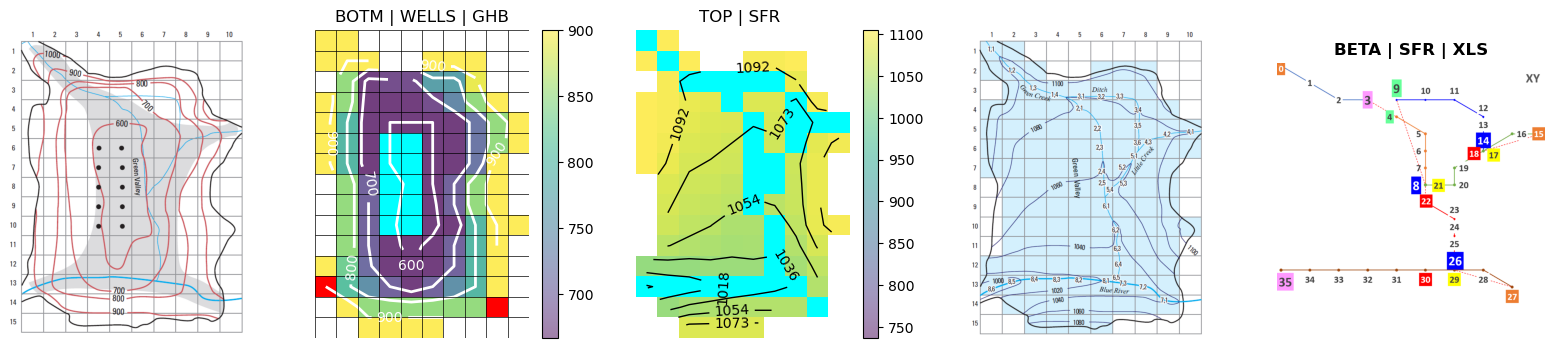

Diversion :  [[3, 0, 9, 'UPTO']]
WELs_OBS_F: {1: [[0, 5, 3, -10.0], [0, 5, 4, -10.0], [0, 6, 3, -10.0], [0, 6, 4, -10.0], [0, 7, 3, -10.0], [0, 7, 4, -10.0], [0, 8, 3, -10.0], [0, 8, 4, -10.0], [0, 9, 3, -10.0], [0, 9, 4, -10.0]], 2: [[]]}


In [5]:
fig = plt.figure(figsize=(20, 4), dpi=100)                                                               ; VMIN=np.max(BOTM[0])/1.5 ; VMAX=np.max(BOTM[0])*.9
ax = fig.add_subplot(151)            ; image=plt.imread(REF1/'SRF1.png')     ; ax.imshow(image) ;ax.axis('off')       
ax = fig.add_subplot(152)            ; mm=flopy.plot.PlotMapView(GWF,ax=ax)   ; CO=mm.plot_array(BOTM ,vmin=VMIN                 ,vmax=VMAX,masked_values=(0,1e30,-1e30),alpha=0.5) 
cbar=plt.colorbar(CO,ax=ax,format="%.0f")    ; plt.axis('off')               ; CW= mm.contour_array(BOTM,levels=LEV,linewidths=2,linestyles="-",colors="white",masked_values=(0, 1e30, -1e30)) 
mm.plot_bc("GHB", color="red")  ; mm.plot_bc("WEL",color="cyan",kper=1) ; ax.set_title("BOTM | WELLS | GHB")  ; mm.plot_grid(lw=0.5, color="black")  ; plt.clabel(CW, fmt="%1.0f")

ax = fig.add_subplot(153)            ; ax.set_title("TOP | SFR ")  ;plt.axis('off') ; # ______________________________________________________________________________________
mm=flopy.plot.PlotMapView(GWF,ax=ax)  ;TC=mm.plot_array(TOP,vmin=np.max(TOP[0])/1.5,vmax=np.max(TOP[0]),masked_values=(0,1e30,-1e30),alpha=0.5)       ; cbar=plt.colorbar(TC,ax=ax, format="%.0f")
mm.plot_bc("SFR", color="cyan") ; CV = mm.contour_array(TOP,levels=LT,linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))     ; plt.clabel(CV, fmt="%1.0f")

ax = fig.add_subplot(154)            ;image=plt.imread(REF1/'SRF2.png') ;ax.imshow(image) ;ax.axis('off')   
ax = fig.add_subplot(155)            ;image=plt.imread(REF1/'BXLS.png') ;ax.imshow(image) ;ax.axis('off')     ; ax.set_title("BETA | SFR | XLS",fontweight="bold") ; plt.show()

print('Diversion : ', SFR_D)   ; print('WELs_OBS_F:', WEL_S) #import xlwings as xw ; wb = xw.Book('E:/15_REPOS/02_Beta-Me/Beta_xls/11_15_51_SFR.xlsx')  ; wb.sheets['b'].activate()

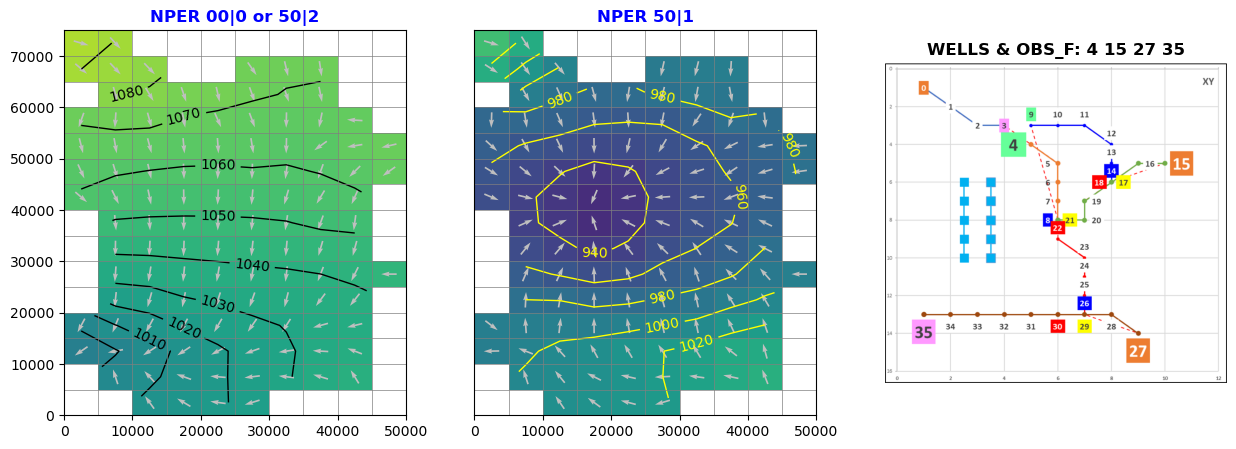

In [6]:
fig = plt.figure(figsize=(15, 5))     ;extents = (0.0,delr*ncol,0.0,delc*nrow)             # ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))
ax = fig.add_subplot(131)   # _______________________________________________________________________________________________________    
mm=flopy.plot.PlotMapView(GWF,ax=ax,extent=extents)  ;HC=mm.plot_array(head0,vmin=900,vmax=1120,masked_values=(0,1e30,-1e30))     ;ax.set_title('NPER 00|0 or 50|2',fontweight='bold', color='blue')
CV = mm.contour_array(head0,levels=np.arange(900, 1100, 10),linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(CV, fmt="%1.0f") ; mm.plot_vector(QX0, QY0, normalize=True, color="0.75")   ;mm.plot_grid(lw=0.5)  
ax = fig.add_subplot(132)   # _______________________________________________________________________________________________________
mn = flopy.plot.PlotMapView(GWF,ax=ax,extent=extents) ;HC=mn.plot_array(head1,vmin=900,vmax=1120,masked_values=(0, 1e30,-1e30))   ;ax.set_title('NPER 50|1',fontweight='bold',color='b')  
CV = mn.contour_array(head1,levels=np.arange(900, 1100, 20),linewidths=1,linestyles="-",colors="yellow",masked_values=(0, 1e30, -1e30))
plt.clabel(CV, fmt="%1.0f") ; mn.plot_vector(QX1, QY1, normalize=True, color="0.75")   ;mn.plot_grid(lw=0.5)                               ; ax.yaxis.set_visible(False) 
ax = fig.add_subplot(133)   ; image=plt.imread(REF1/'BXLS_2.png') ;ax.imshow(image) ;ax.axis('off')         ; ax.set_title("WELLS & OBS_F: 4 15 27 35",fontweight="bold") ; plt.show()

PUMP RATE (cu-ft/s): {1: [[0, 5, 3, -10.0], [0, 5, 4, -10.0], [0, 6, 3, -10.0], [0, 6, 4, -10.0], [0, 7, 3, -10.0], [0, 7, 4, -10.0], [0, 8, 3, -10.0], [0, 8, 4, -10.0], [0, 9, 3, -10.0], [0, 9, 4, -10.0]], 2: [[]]}


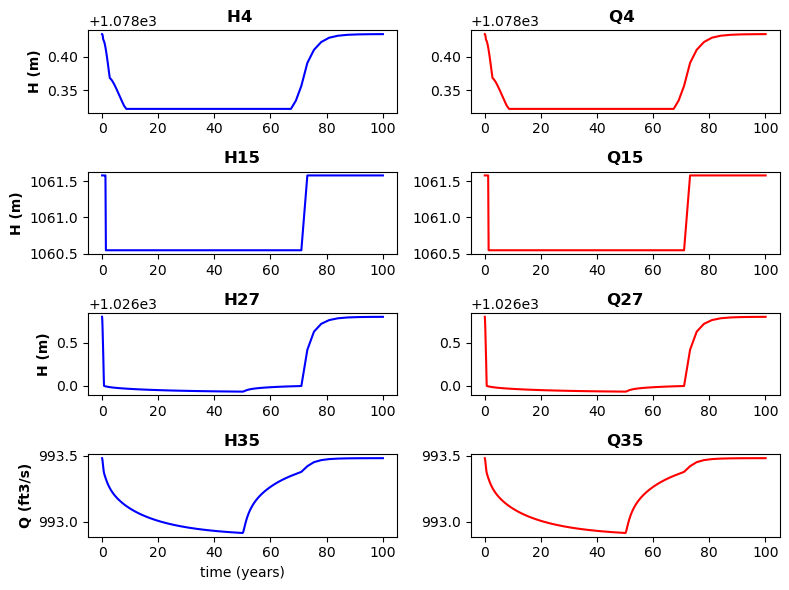

,time,H4,H15,H27,H35,Q4,Q15,Q27,Q35,time2
99,3.011084e+09,1078.434093,1061.581,1026.800423,993.482807,17.168731,6.349241,15.024821,186.244036,95.480845
100,3.155760e+09,1078.434209,1061.581,1026.801221,993.482960,17.173628,6.356151,15.046811,186.273603,100.068493


In [7]:
DF=pd.read_csv(T11b/'e11.sfr.obs.csv') ;DF['Q4']=DF['Q4']*-1;DF['Q15']=DF['Q15']*-1;DF['Q27']=DF['Q27']*-1;DF['Q35']=DF['Q35']*-1  ;DF['time2']=DF['time']/(365*86400); print('PUMP RATE (cu-ft/s):',WEL_S)
fig = plt.figure(figsize=(8,6))                                                                           ;AA=[DF.columns[1]]       ;BB=[DF.columns[1]]
ax = fig.add_subplot(421) ; ax.plot(DF['time2'],DF[AA],color='b')  ;ax.set_title("H4 ",fontweight="bold") ;ax.set_ylabel("H (m)"    ,fontweight="bold") 
ax = fig.add_subplot(422) ; ax.plot(DF['time2'],DF[BB],color='r')  ;ax.set_title("Q4 ",fontweight="bold") ;AA=[DF.columns[2]]       ;BB=[DF.columns[2]]
ax = fig.add_subplot(423) ; ax.plot(DF['time2'],DF[AA],color='b')  ;ax.set_title("H15",fontweight="bold") ;ax.set_ylabel("H (m)"    ,fontweight="bold") 
ax = fig.add_subplot(424) ; ax.plot(DF['time2'],DF[BB],color='r')  ;ax.set_title("Q15",fontweight="bold") ;AA=[DF.columns[3]]       ;BB=[DF.columns[3]]
ax = fig.add_subplot(425) ; ax.plot(DF['time2'],DF[AA],color='b')  ;ax.set_title("H27",fontweight="bold") ;ax.set_ylabel("H (m)"    ,fontweight="bold") 
ax = fig.add_subplot(426) ; ax.plot(DF['time2'],DF[BB],color='r')  ;ax.set_title("Q27",fontweight="bold") ;AA=[DF.columns[4]]       ;BB=[DF.columns[4]]
ax = fig.add_subplot(427) ; ax.plot(DF['time2'],DF[AA],color='b')  ;ax.set_title("H35",fontweight="bold") ;ax.set_ylabel("Q (ft3/s)",fontweight="bold") ;ax.set_xlabel("time (years)") 
ax = fig.add_subplot(428) ; ax.plot(DF['time2'],DF[BB],color='r')  ;ax.set_title("Q35",fontweight="bold") ;plt.tight_layout(); plt.show() ; DF.tail(2)

In [8]:
pd.DataFrame(os.listdir(T11/'b')).to_csv(T11/"_01_LIST.csv")              # SFR_P; SFR_C; SFR_D; SFR_S     ;GHB_S; WEL_S; IDO; TOP; RCH; SURF     ; OBS_F; OBS_D   # export
np.savetxt(T11/"_01_SP.csv",SFR_P,delimiter=",");pd.DataFrame(SFR_C).to_csv(T11/"_02_SC.csv")   ;np.savetxt(T11/"_03_SD.csv",SFR_D,fmt="%s",delimiter=",");pd.DataFrame(SFR_S).to_csv(T11/"_04_SS.csv")
np.savetxt(T11/"_05_IDO.csv",IDO,delimiter=",") ;np.savetxt(T11/"_05_TOP.csv",TOP,delimiter=",");np.savetxt(T11/"_05_RCH.csv",RCH,delimiter=",")  ;np.savetxt(T11/"_05_SURF_W.csv",SURF,delimiter=",")
np.savetxt(T11/"_05_GHB_spd.csv",GHB_S,delimiter=",")  ; pd.DataFrame(OBS_D).to_csv(T11/"_05_OBS_D.csv")  
with open(T11/"_06_WEL_spd.csv", "w", newline="") as ff:     # _____________________________________________ saving
    mm = csv.DictWriter(ff, WEL_S.keys())   ; mm.writeheader()  ; mm.writerow(WEL_S)
with open(T11/"_07_OBS_F.csv", 'w', newline='')   as csvfile:  # _____________________________________________ saving
    writer = csv.writer(csvfile)
    for line in OBS_F.splitlines():           writer.writerow(line.split(','))
shutil.copy(T11b/'e11.sfr.obs.csv', T11/'_08_OBS_F2.csv')                     # ; BE1 = pd.read_csv(T11/"_01_SP.csv", header=None).values.tolist()               # Bxls_sfr_P.csv
n='n'                                                                          ; SFR_P = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).values.tolist()   # Bxls_sfr_P.csv
df = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')  ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()                         # Bxls_sfr_C.csv
n='n'                                                                          ; SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).values.tolist()   # Bxls_sfr_S.csv

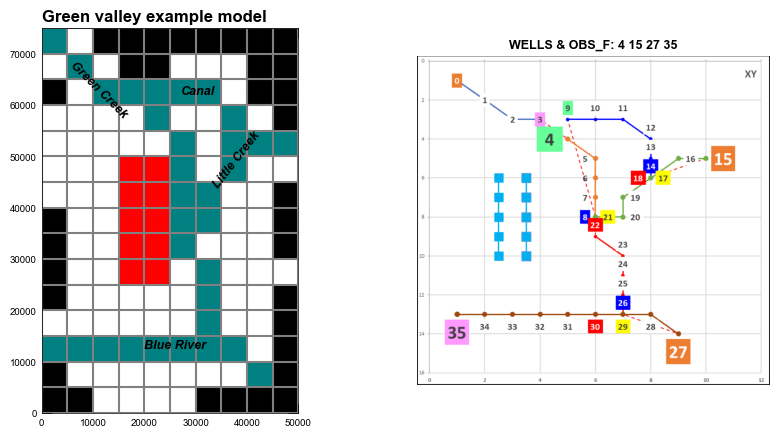

In [9]:
fig = plt.figure(figsize=(10, 5))     ;extents = (0.0,delr*ncol,0.0,delc*nrow)             # ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))

with styles.USGSMap():
    ax = fig.add_subplot(121)
    pmv = flopy.plot.PlotMapView(GWF,) ; pmv.plot_inactive() ; pmv.plot_grid() ; pmv.plot_bc("SFR") ; pmv.plot_bc("WEL", plotAll=True,kper=1)
    styles.heading(ax=ax, heading="Green valley example model", fontsize=12)    
    styles.add_text(ax,text="Green Creek",x=0.10,y=0.76,bold=True,rotation=-45,fontsize=9,) ; styles.add_text(ax, text="Canal", x=0.54, y=0.82, bold=True, fontsize=9)
    styles.add_text(ax,text="Little Creek",x=0.66,y=0.58,bold=True,rotation=52,fontsize=9,) ; styles.add_text(ax, text="Blue River", x=0.40, y=0.16, bold=True, fontsize=9)
    ax = fig.add_subplot(122)   ; image=plt.imread(REF1/'BXLS_2.png') ;ax.imshow(image) ;ax.axis('off')         ; ax.set_title("WELLS & OBS_F: 4 15 27 35",fontweight="bold") ; plt.show()

### **The Scenario:**
Green Valley Water wants to begin pumping <font color='blue'> **10 public supply wells** </font> near Green Creek at the <font color='blue'> **rate of 10 cu-ft/s.** </font> However, Green Creek provides import spawing habitat for a population of California Golden Trout that primarily lives in Blue River. It's been noted that 
<font color='red'> **stream levels dropping to less than 5" or about 0.42 ft could have negative impacts on the trout population.** </font>

<font color='blue'> **The task ___ is to find a sustainable long term pumping rates while maintaining in stream flows.** </font>

In [10]:
reach_info = {3: ("H4", "Upper Green Creek"),14: ("H15", "Little Creek"),26: ("H27", "Lower Green Creek"),35: ("H35", "Blue River"),}
RTOPS = GWF.sfr.packagedata.array["rtp"]
for rno, (rtag, name) in reach_info.items():     NEWC = f"{rtag}_depth"   ; stage_col = f"{rtag}" ; rtop = RTOPS[rno]     ;DF[NEWC]=DF[stage_col]-rtop      
DF.head(7)

,time,H4,H15,H27,H35,Q4,Q15,Q27,Q35,time2,H4_depth,H15_depth,H27_depth,H35_depth
0,0.000000e+00,1078.434282,1061.581,1026.801722,993.483058,17.176708,6.360428,15.060657,186.292330,0.000000,1.026282,1.036,0.892722,1.608058
1,1.355674e+06,1078.434197,1061.581,1026.785580,993.480665,17.171668,6.351391,14.618193,185.834297,0.042988,1.026197,1.036,0.876580,1.605665
2,2.846914e+06,1078.433910,1061.581,1026.753606,993.475662,17.154748,6.318223,13.757693,184.876887,0.090275,1.025910,1.036,0.844606,1.600662
3,4.487279e+06,1078.433308,1061.581,1026.705680,993.467920,17.119358,6.242813,12.508150,183.398342,0.142291,1.025308,1.036,0.796680,1.592920
4,6.291681e+06,1078.432293,1061.581,1026.641072,993.457419,17.060136,6.107030,10.901716,181.399490,0.199508,1.024293,1.036,0.732072,1.582419
5,8.276523e+06,1078.430788,1061.581,1026.558761,993.444320,16.973141,5.893674,8.988895,178.917165,0.262447,1.022788,1.036,0.649761,1.569320
6,1.045985e+07,1078.428728,1061.581,1026.471897,993.430487,16.855645,5.591869,7.138988,176.309085,0.331680,1.020728,1.036,0.562897,1.555487


In [11]:
idxs = np.where(DF["H27_depth"].values < 0.15)[0]   ; idx = list(sorted(idxs))[0]   ; DF2 = DF.reset_index()  ; DF3 = pd.DataFrame(DF2.iloc[idx])
years_pumped = (DF2.loc[idx, "time"] - DF2.loc[0, "time"]) / (365.25 * 86400)        ; print(f"{years_pumped=:.2f}")     ; DF3.T        # And to calculate the number of years of pumping

years_pumped=0.68


,index,time,H4,H15,H27,H35,Q4,Q15,Q27,Q35,time2,H4_depth,H15_depth,H27_depth,H35_depth
10,10.0,2.160594e+07,1078.423687,1061.581,1025.999088,993.371179,16.630786,3.415238,0.629652,165.291922,0.68512,1.015687,1.036,0.090088,1.496179


In [12]:
_DLL_PATH= Path(os.getenv("CONDA_PREFIX"))   ;_DLL_PATH=_DLL_PATH / "Scripts"  ;libmf6 = (_DLL_PATH / f"libmf6.dll").resolve() ; 
mf6 = modflowapi.ModflowApi(libmf6, working_directory=T11b)  ; mf6.initialize()
dt = mf6.get_time_step()   ; mf6.prepare_time_step(dt)      # advancing the model to the first timestep

In [ ]:
ivn = mf6.get_input_var_names()     ; sfr_vars = [i for i in ivn if "SFR_0" in i]     ; print(sfr_vars)                 ; sfr_var_interest = []
for i in sfr_vars: 
    if "OUTFLOW" in i or "STAGE" in i or "STRTOP" in i:                                 sfr_var_interest.append(i)
print(sfr_var_interest)     ; mf6.finalize()

['E11/SFR_0/INPUT_FNAME', 'E11/SFR_0/PACKAGE_TYPE', 'E11/SFR_0/ID', 'E11/SFR_0/INUNIT', 'E11/SFR_0/IOUT', 'E11/SFR_0/INEWTON', 'E11/SFR_0/IASYM', 'E11/SFR_0/IPRPAK', 'E11/SFR_0/IPRFLOW', 'E11/SFR_0/IPAKCB', 'E11/SFR_0/IONPER', 'E11/SFR_0/LASTONPER', 'E11/SFR_0/LISTLABEL', 'E11/SFR_0/ISADVPAK', 'E11/SFR_0/IBCNUM', 'E11/SFR_0/MAXBOUND', 'E11/SFR_0/NBOUND', 'E11/SFR_0/NCOLBND', 'E11/SFR_0/ISCLOC', 'E11/SFR_0/NAUX', 'E11/SFR_0/INAMEDBOUND', 'E11/SFR_0/IAUXMULTCOL', 'E11/SFR_0/INOBSPKG', 'E11/SFR_0/IMOVER', 'E11/SFR_0/IVSC', 'E11/SFR_0/NPAKEQ', 'E11/SFR_0/IOFFSET', 'E11/SFR_0/AUXNAME', 'E11/SFR_0/AUXNAME_CST', 'E11/SFR_0/IPRHED', 'E11/SFR_0/ISTAGEOUT', 'E11/SFR_0/IBUDGETOUT', 'E11/SFR_0/IBUDCSV', 'E11/SFR_0/IPAKCSV', 'E11/SFR_0/IDIVERSIONS', 'E11/SFR_0/MAXSFRPICARD', 'E11/SFR_0/MAXSFRIT', 'E11/SFR_0/BDITEMS', 'E11/SFR_0/CBCAUXITEMS', 'E11/SFR_0/UNITCONV', 'E11/SFR_0/LENGTHCONV', 'E11/SFR_0/TIMECONV', 'E11/SFR_0/DMAXCHG', 'E11/SFR_0/DEPS', 'E11/SFR_0/NCONN', 'E11/SFR_0/ICHECK', 'E11/SFR_0/IC

In [ ]:
# ... to be continues